### DATA 620
#### Project 2   
### [Video Presentation]()
##### Group Four
- Santosh Cheruku
- Vinicio Haro
- Javern Wilson
- Saayed Alam  

In [173]:
# load libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from networkx.algorithms import bipartite as bi
from collections import Counter
% matplotlib inline

In this assignment, we are asked to identify a large 2-node network dataset. The data meets the criteria that it consists of ties between and not within two (or more) distinct groups.

In [177]:
appear = pd.read_csv("https://raw.githubusercontent.com/saayedalam/Data/master/out.actor-movie",
                  header = None, skiprows = 1, sep = " ").rename(columns = {0: "movie", 1: "actor", 2: "appearance"})

Since the dataset has more than a million edges, we will first sample only 2% of the dataset. We also built a weight variable which is the number of appearances an actor has made in movies. The more appearances an actor has, the more experience he has. 

In [178]:
appear['appearance'] = appear.groupby(['actor',]).actor.transform('count')
appear = appear.sample(frac = 0.2, random_state = 1)
appear.head()

,movie,actor,appearance
669792,58971,99903,5
408148,38329,55750,6
485488,44144,15249,71
697835,61268,86461,28
181724,20856,1940,28


In [192]:
appear.sort_values(by = "appearance", ascending = False)

,movie,actor,appearance
1206198,100791,108075,646
1194947,99796,108075,646
1295462,107992,108075,646
1421822,120285,108075,646
1195318,99842,108075,646
1234158,103052,108075,646
1194998,99803,108075,646
1195762,99894,108075,646
1204442,100590,108075,646
1253113,104608,108075,646


In [179]:
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(list(appear.movie.values), bipartite=0)
B.add_nodes_from(list(appear.actor.values), bipartite=1)

# Add edges only between nodes of opposite node sets
subset = appear[['movie', 'actor', 'appearance']]
edges_tuples = [tuple(x) for x in subset.values]
B.add_weighted_edges_from(edges_tuples)

In [180]:
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 183099
Number of edges: 294076
Average degree:   3.2122


We reduce the size of the network by island method. The island method works as follows: imagine our network as an island with a complex terrain, where the height of each point on the terrain is defined by the value of a node (number of appearances). Now let us imagine that the water level around this island is rising slowly, leaving portions of the landscape underwater. When the valleys in the island are flooded, the island essentially splits into smaller islands—revealing where the highest peaks are, and making these peaks smaller.

In [169]:
#####
## islands method
# taken from SNA chp 4 pg 64.  Modified appropriately.
########

def trim_edges(g, weight = 1):
    edges = []
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight']> weight:
            x = float(edata['weight'])
            edges.append((f,to,x))
    g2.add_weighted_edges_from(edges)
    return g2


def island_method(g, iterations=5):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    
    #size of step
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

In our case for example, threshold 4 represents 517 appearances by 128 actors. These actors could be background actors. 

In [190]:
values = [['Threshold','Appearances']]
islands = island_method(B, iterations = 5)
for x in islands:
    threshold =x[0]
    num_people = len(x[1])
    #connections = len(list(nx.connected_component_subgraphs(x[1])))
    temp_list = [threshold, num_people]
    values.append(temp_list)
    
headers = values.pop(0)
islan_df = pd.DataFrame(values,columns = headers)
islan_df

,Threshold,Appearances
0,1,138870
1,130,10929
2,259,1424
3,388,607
4,517,128


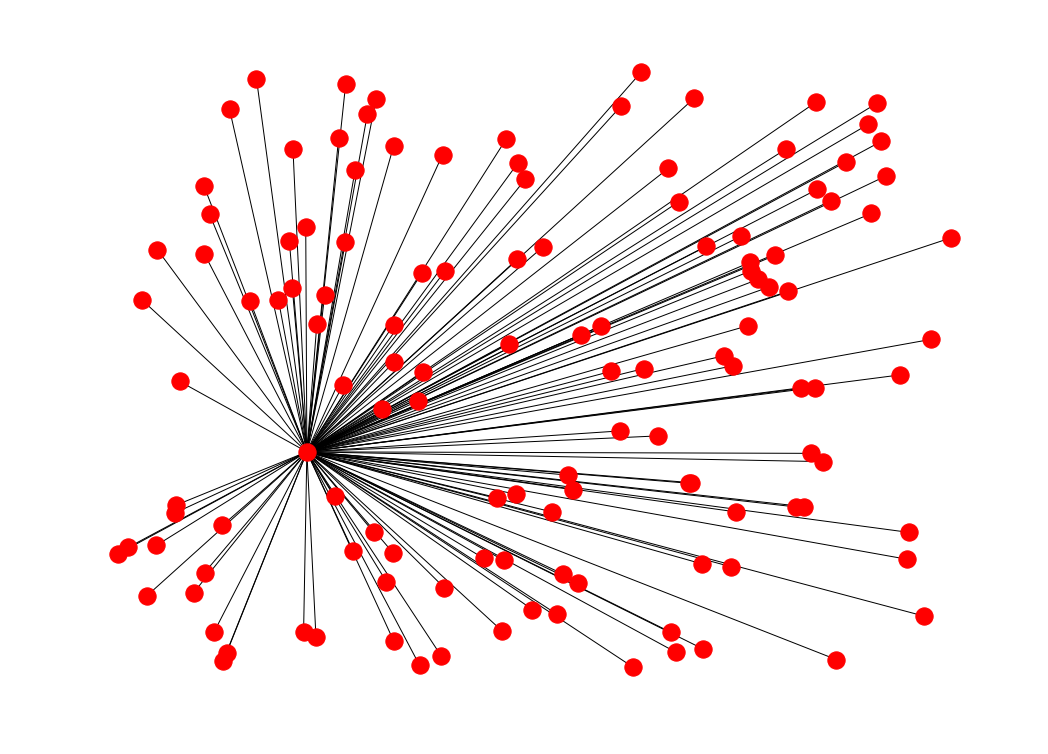

In [211]:
plt.figure(figsize=(14, 10))
island_plot = trim_edges(B, 517)
pos=nx.random_layout(island_plot)
nx.draw(island_plot, pos)
plt.axis('off')
plt.show()

For finding very connected actors, popular actors who are likely to hold most information or actors who can quickly connect with the wider network, we use degree centrality. The actor with most connection has 129 connections. 

In [189]:
# degree centrality
deg = nx.degree(B)
max(dict(deg).values())

129

In [193]:
## Project one side of the graph:
#plt.figure(figsize = (12,12))
#G = nx.projected_graph(B, appear.actor)
#nx.draw(G,pos=nx.spring_layout(G), with_labels = True, node_color = 'blue')